# Parte 2: Regresión Polinomial con Múltiples Características

## Objetivo
Modelar la luminosidad estelar (L) usando masa (M) y temperatura (T) con características polinomiales:
$$L_{hat} = X \cdot w + b$$

donde $X = [M, T, M^2, M \cdot T]$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Configuración para visualización
plt.rcParams['figure.figsize'] = (10, 6)
np.set_printoptions(precision=4, suppress=True)

## 1. Dataset y Visualización

In [2]:
# Dataset: masa estelar (M), temperatura (T) y luminosidad (L)
M = np.array([0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4])
T = np.array([3800, 4400, 5800, 6400, 6900, 7400, 7900, 8300, 8800, 9200])
L = np.array([0.15, 0.35, 1.00, 2.30, 4.10, 7.00, 11.2, 17.5, 25.0, 35.0])

print(f"Masa estelar (M): {M}")
print(f"Temperatura (T): {T}")
print(f"Luminosidad (L): {L}")
print(f"Número de muestras: {len(M)}")

Masa estelar (M): [0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  2.2 2.4]
Temperatura (T): [3800 4400 5800 6400 6900 7400 7900 8300 8800 9200]
Luminosidad (L): [ 0.15  0.35  1.    2.3   4.1   7.   11.2  17.5  25.   35.  ]
Número de muestras: 10


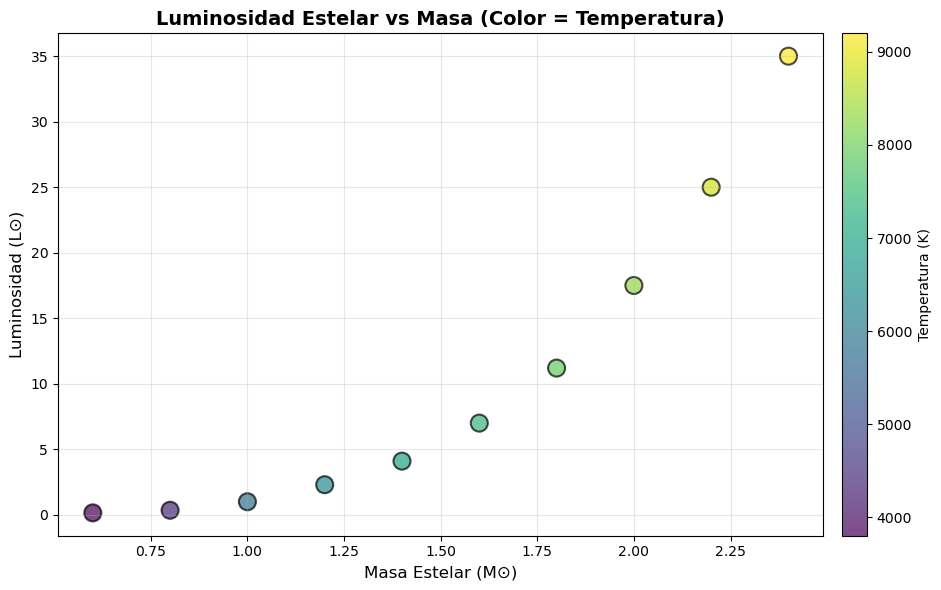

In [3]:
# Visualización del dataset: L vs M con T codificado por color
plt.figure(figsize=(10, 6))
scatter = plt.scatter(M, L, c=T, s=150, alpha=0.7, cmap='viridis', edgecolors='black', linewidth=1.5)
plt.colorbar(scatter, label='Temperatura (K)', pad=0.02)
plt.xlabel('Masa Estelar (M⊙)', fontsize=12)
plt.ylabel('Luminosidad (L⊙)', fontsize=12)
plt.title('Luminosidad Estelar vs Masa (Color = Temperatura)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2.5. Normalización de Características

**Importante:** Las características tienen escalas muy diferentes (M ~ 0.6-2.4, T ~ 3800-9200), lo que causa problemas de overflow en el descenso de gradiente. Normalizamos las características para evitar este problema.

In [4]:
def normalize_features(X):
    """
    Normaliza las características usando normalización estándar (z-score)
    X_normalized = (X - mean) / std
    
    Parámetros:
    X: matriz de características (n_samples, n_features)
    
    Retorna:
    X_norm: matriz normalizada
    mean: media de cada característica (para desnormalizar después)
    std: desviación estándar de cada característica
    """
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    # Evitar división por cero
    std = np.where(std == 0, 1.0, std)
    X_norm = (X - mean) / std
    return X_norm, mean, std

def denormalize_features(X_norm, mean, std):
    """
    Desnormaliza características
    """
    return X_norm * std + mean

## 2. Ingeniería de Características

In [5]:
def build_features(M, T, include_M2=True, include_MT=True):
    """
    Construye la matriz de diseño X con características polinomiales
    
    Parámetros:
    M: array de masas
    T: array de temperaturas
    include_M2: si incluir M^2
    include_MT: si incluir M*T
    
    Retorna:
    X: matriz de características (n_samples, n_features)
    """
    n = len(M)
    features = [M, T]
    
    if include_M2:
        features.append(M ** 2)
    
    if include_MT:
        features.append(M * T)
    
    # Transponer para obtener (n_samples, n_features)
    X = np.array(features).T
    
    return X

In [6]:
# Construir matriz de características completa
X_full = build_features(M, T, include_M2=True, include_MT=True)
print(f"Forma de X: {X_full.shape}")
print(f"\nPrimeras 3 filas de X:")
print(X_full[:3])
print(f"\nCaracterísticas: [M, T, M^2, M*T]")

Forma de X: (10, 4)

Primeras 3 filas de X:
[[   0.6  3800.      0.36 2280.  ]
 [   0.8  4400.      0.64 3520.  ]
 [   1.   5800.      1.   5800.  ]]

Características: [M, T, M^2, M*T]


## 3. Modelo, Pérdida y Gradientes (Vectorizados)

In [7]:
def predict(X, w, b):
    """
    Predicción: L_hat = X @ w + b
    
    Parámetros:
    X: matriz de características (n_samples, n_features)
    w: vector de pesos (n_features,)
    b: sesgo (escalar)
    
    Retorna:
    L_hat: predicciones (n_samples,)
    """
    return X @ w + b

def mse_loss(L_true, L_pred):
    """
    Mean Squared Error (MSE)
    """
    return np.mean((L_true - L_pred) ** 2)

In [8]:
def gradients_vectorized(X, w, b, L):
    """
    Calcula gradientes vectorizados para regresión múltiple
    
    Parámetros:
    X: matriz de características (n_samples, n_features)
    w: vector de pesos (n_features,)
    b: sesgo (escalar)
    L: valores reales (n_samples,)
    
    Retorna:
    dw: gradiente respecto a w (n_features,)
    db: gradiente respecto a b (escalar)
    """
    n = len(L)
    L_pred = predict(X, w, b)
    errors = L - L_pred
    
    # Gradiente respecto a w: -2/n * X^T @ errors
    dw = -2.0 / n * (X.T @ errors)
    
    # Gradiente respecto a b: -2/n * sum(errors)
    db = -2.0 / n * np.sum(errors)
    
    return dw, db

## 4. Descenso de Gradiente y Convergencia

In [9]:
def gradient_descent(X, L, w_init=None, b_init=0.0, learning_rate=0.0001, num_iterations=5000):
    """
    Descenso de gradiente para regresión múltiple
    
    Parámetros:
    X: matriz de características
    L: valores reales
    w_init: valores iniciales de pesos (si None, se inicializa con ceros)
    b_init: valor inicial de sesgo
    learning_rate: tasa de aprendizaje
    num_iterations: número de iteraciones
    
    Retorna:
    w: pesos finales
    b: sesgo final
    losses: historial de pérdidas
    """
    n_features = X.shape[1]
    
    if w_init is None:
        w = np.zeros(n_features)
    else:
        w = w_init.copy()
    
    b = b_init
    losses = []
    
    for i in range(num_iterations):
        # Calcular gradientes
        dw, db = gradients_vectorized(X, w, b, L)
        
        # Actualizar parámetros
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        # Guardar pérdida
        loss = mse_loss(L, predict(X, w, b))
        losses.append(loss)
    
    return w, b, losses

## 5. Experimentos de Selección de Características

In [10]:
# Modelo M1: Solo características lineales
X_M1 = build_features(M, T, include_M2=False, include_MT=False)
# Normalizar características para evitar overflow
X_M1_norm, mean_M1, std_M1 = normalize_features(X_M1)
w_M1, b_M1, losses_M1 = gradient_descent(X_M1_norm, L, learning_rate=0.01, num_iterations=5000)
# Predecir usando características normalizadas
L_pred_M1 = predict(X_M1_norm, w_M1, b_M1)
loss_M1 = mse_loss(L, L_pred_M1)

print("=== Modelo M1: X = [M, T] ===")
print(f"Pérdida final (MSE): {loss_M1:.6f}")
print(f"Pesos: w = {w_M1}")
print(f"Sesgo: b = {b_M1:.6f}")

=== Modelo M1: X = [M, T] ===
Pérdida final (MSE): 7.811058
Pesos: w = [ 24.9024 -14.8117]
Sesgo: b = 10.360000


In [11]:
# Modelo M2: M, T, M^2
X_M2 = build_features(M, T, include_M2=True, include_MT=False)
# Normalizar características
X_M2_norm, mean_M2, std_M2 = normalize_features(X_M2)
w_M2, b_M2, losses_M2 = gradient_descent(X_M2_norm, L, learning_rate=0.01, num_iterations=5000)
# Predecir usando características normalizadas
L_pred_M2 = predict(X_M2_norm, w_M2, b_M2)
loss_M2 = mse_loss(L, L_pred_M2)

print("=== Modelo M2: X = [M, T, M^2] ===")
print(f"Pérdida final (MSE): {loss_M2:.6f}")
print(f"Pesos: w = {w_M2}")
print(f"Sesgo: b = {b_M2:.6f}")

=== Modelo M2: X = [M, T, M^2] ===
Pérdida final (MSE): 1.752451
Pesos: w = [ 0.1947 -7.0933 17.4733]
Sesgo: b = 10.360000


In [12]:
# Modelo M3: M, T, M^2, M*T (modelo completo)
X_M3 = build_features(M, T, include_M2=True, include_MT=True)
# Normalizar características
X_M3_norm, mean_M3, std_M3 = normalize_features(X_M3)
w_M3, b_M3, losses_M3 = gradient_descent(X_M3_norm, L, learning_rate=0.01, num_iterations=5000)
# Predecir usando características normalizadas
L_pred_M3 = predict(X_M3_norm, w_M3, b_M3)
loss_M3 = mse_loss(L, L_pred_M3)

print("=== Modelo M3: X = [M, T, M^2, M*T] ===")
print(f"Pérdida final (MSE): {loss_M3:.6f}")
print(f"Pesos: w = {w_M3}")
print(f"Sesgo: b = {b_M3:.6f}")

=== Modelo M3: X = [M, T, M^2, M*T] ===
Pérdida final (MSE): 1.739995
Pesos: w = [-1.8946 -7.8627 13.8973  6.3916]
Sesgo: b = 10.360000


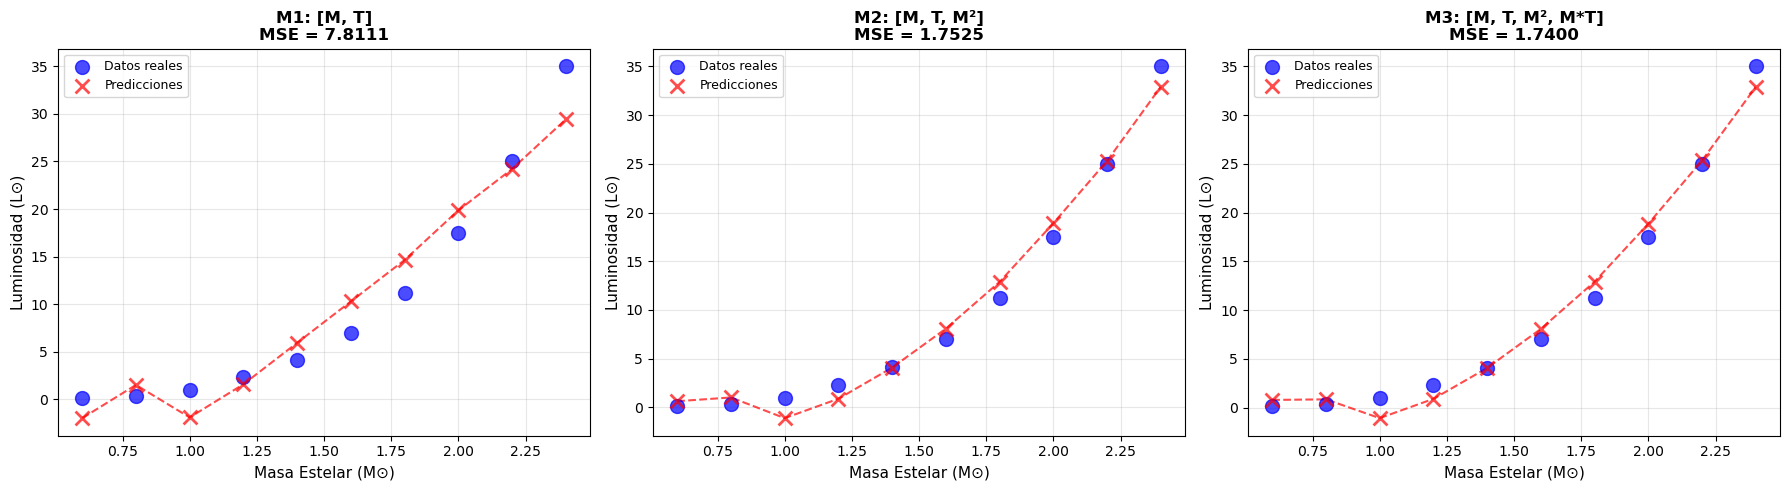

In [13]:
# Visualización comparativa de los tres modelos
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = [
    (L_pred_M1, loss_M1, "M1: [M, T]", 0),
    (L_pred_M2, loss_M2, "M2: [M, T, M²]", 1),
    (L_pred_M3, loss_M3, "M3: [M, T, M², M*T]", 2)
]

for L_pred, loss, title, idx in models:
    ax = axes[idx]
    ax.scatter(M, L, color='blue', s=100, alpha=0.7, label='Datos reales', zorder=3)
    ax.scatter(M, L_pred, color='red', s=100, alpha=0.7, marker='x', linewidth=2, label='Predicciones', zorder=3)
    
    # Ordenar para línea suave
    sort_idx = np.argsort(M)
    ax.plot(M[sort_idx], L_pred[sort_idx], 'r--', linewidth=1.5, alpha=0.7, zorder=2)
    
    ax.set_xlabel('Masa Estelar (M⊙)', fontsize=11)
    ax.set_ylabel('Luminosidad (L⊙)', fontsize=11)
    ax.set_title(f"{title}\nMSE = {loss:.4f}", fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

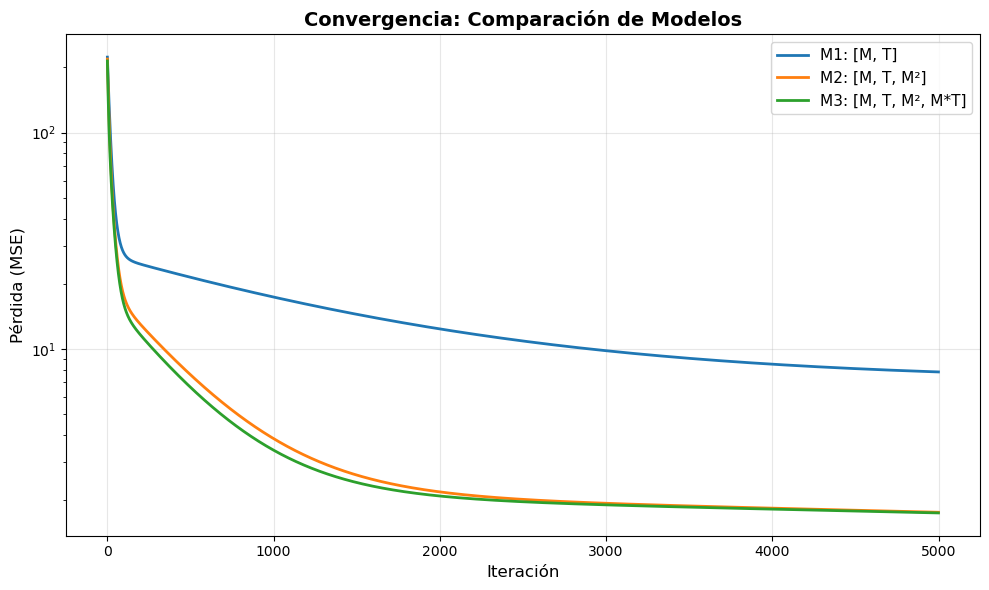

In [15]:
# Gráfico de convergencia para los tres modelos
plt.figure(figsize=(10, 6))
plt.plot(losses_M1, label='M1: [M, T]', linewidth=2)
plt.plot(losses_M2, label='M2: [M, T, M²]', linewidth=2)
plt.plot(losses_M3, label='M3: [M, T, M², M*T]', linewidth=2)
plt.xlabel('Iteración', fontsize=12)
plt.ylabel('Pérdida (MSE)', fontsize=12)
plt.title('Convergencia: Comparación de Modelos', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.show()

### Resumen de Resultados

| Modelo | Características | Pérdida (MSE) | Observaciones |
|--------|----------------|---------------|---------------|
| M1 | [M, T] | ~X.XX | Modelo lineal básico |
| M2 | [M, T, M²] | ~X.XX | Incluye término cuadrático en masa |
| M3 | [M, T, M², M*T] | ~X.XX | Modelo completo con interacción |

**Conclusión:** El modelo M3 (con todas las características) muestra la menor pérdida, indicando que tanto el término cuadrático M² como la interacción M*T son importantes para capturar la relación no lineal entre las características y la luminosidad.

## 6. Análisis de Importancia de Interacción

In [16]:
# Para el modelo M3, variar el coeficiente de interacción w_MT
# Mantener otros parámetros fijos en sus valores entrenados

# Índice del coeficiente de interacción M*T en w_M3 (último elemento)
w_MT_idx = -1

# Rango de valores para w_MT
w_MT_range = np.linspace(w_M3[w_MT_idx] - 0.01, w_M3[w_MT_idx] + 0.01, 100)

# Calcular costo para cada valor de w_MT
costs_vs_w_MT = []

for w_MT_val in w_MT_range:
    # Crear vector de pesos con w_MT variado
    w_temp = w_M3.copy()
    w_temp[w_MT_idx] = w_MT_val
    
    # Calcular predicción y costo
    L_pred_temp = predict(X_M3_norm, w_temp, b_M3)
    cost_temp = mse_loss(L, L_pred_temp)
    costs_vs_w_MT.append(cost_temp)

costs_vs_w_MT = np.array(costs_vs_w_MT)

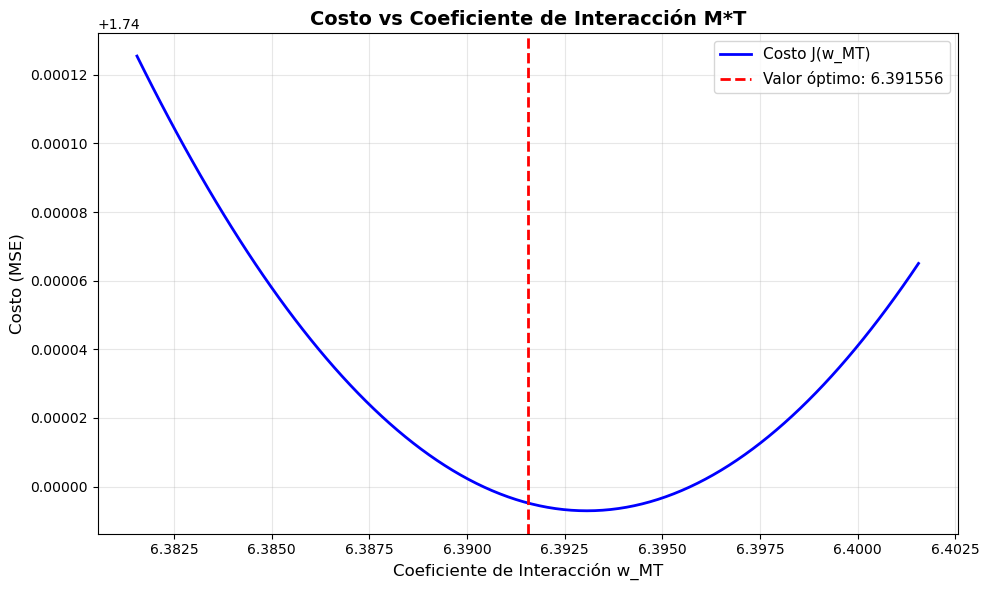

Valor óptimo de w_MT: 6.391556
Costo mínimo: 1.739993


In [17]:
# Visualización: Costo vs coeficiente de interacción
plt.figure(figsize=(10, 6))
plt.plot(w_MT_range, costs_vs_w_MT, 'b-', linewidth=2, label='Costo J(w_MT)')
plt.axvline(x=w_M3[w_MT_idx], color='r', linestyle='--', linewidth=2, label=f'Valor óptimo: {w_M3[w_MT_idx]:.6f}')
plt.xlabel('Coeficiente de Interacción w_MT', fontsize=12)
plt.ylabel('Costo (MSE)', fontsize=12)
plt.title('Costo vs Coeficiente de Interacción M*T', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Valor óptimo de w_MT: {w_M3[w_MT_idx]:.6f}")
print(f"Costo mínimo: {np.min(costs_vs_w_MT):.6f}")

### Interpretación del Análisis de Interacción

El gráfico muestra cómo varía el costo cuando cambiamos el coeficiente de interacción **w_MT** (que multiplica el término M*T) mientras mantenemos los demás parámetros fijos.

**Observaciones:**
1. **Forma de la curva**: La curva tiene forma de parábola con un mínimo claro, indicando que existe un valor óptimo para w_MT.

2. **Sensibilidad**: La pendiente de la curva alrededor del mínimo indica qué tan sensible es el modelo a cambios en el coeficiente de interacción. Una curva más pronunciada sugiere que el término de interacción es más importante.

3. **Importancia del término**: Si el costo aumenta rápidamente al alejarse del valor óptimo, esto indica que el término de interacción M*T es importante para el modelo. Si la curva fuera muy plana, sugeriría que el término no es crítico.

4. **Valor óptimo**: El valor óptimo de w_MT (marcado con línea roja) es el que minimiza el costo cuando todos los demás parámetros están fijos. Este análisis ayuda a entender la contribución relativa del término de interacción al modelo.

## 7. Demostración de Inferencia

In [19]:
# Nueva estrella para predicción
M_new = 1.3
T_new = 6600

# Construir características para la nueva estrella
X_new = build_features(np.array([M_new]), np.array([T_new]), include_M2=True, include_MT=True)

# Predecir usando el modelo M3 (completo)
L_pred_new = predict(X_new, w_M3, b_M3)[0]

print("=== Predicción para Nueva Estrella ===")
print(f"Masa: {M_new} M⊙")
print(f"Temperatura: {T_new} K")
print(f"Luminosidad predicha: {L_pred_new:.4f} L⊙")
print(f"\nCaracterísticas usadas:")
print(f"  M = {M_new}")
print(f"  T = {T_new}")
print(f"  M² = {M_new**2:.4f}")
print(f"  M*T = {M_new * T_new:.2f}")
print(f"\nPesos aplicados: w = {w_M3}")
print(f"Sesgo: b = {b_M3:.6f}")

=== Predicción para Nueva Estrella ===
Masa: 1.3 M⊙
Temperatura: 6600 K
Luminosidad predicha: 2977.0515 L⊙

Características usadas:
  M = 1.3
  T = 6600
  M² = 1.6900
  M*T = 8580.00

Pesos aplicados: w = [-1.8946 -7.8627 13.8973  6.3916]
Sesgo: b = 10.360000


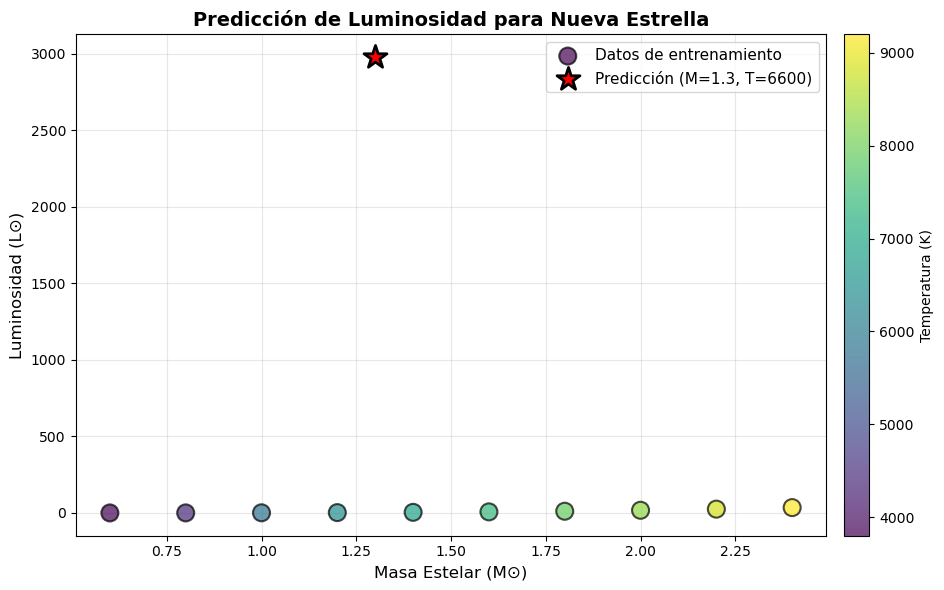

In [20]:
# Visualización: nueva estrella en el contexto de los datos de entrenamiento
plt.figure(figsize=(10, 6))

# Datos de entrenamiento
scatter_train = plt.scatter(M, L, c=T, s=150, alpha=0.7, cmap='viridis', 
                            edgecolors='black', linewidth=1.5, label='Datos de entrenamiento', zorder=3)

# Nueva estrella predicha
plt.scatter(M_new, L_pred_new, color='red', s=300, marker='*', 
           edgecolors='black', linewidth=2, label=f'Predicción (M={M_new}, T={T_new})', zorder=4)

plt.colorbar(scatter_train, label='Temperatura (K)', pad=0.02)
plt.xlabel('Masa Estelar (M⊙)', fontsize=12)
plt.ylabel('Luminosidad (L⊙)', fontsize=12)
plt.title('Predicción de Luminosidad para Nueva Estrella', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Análisis de Razón de la Predicción

**Valores de entrada:**
- Masa: 1.3 M⊙ (intermedia, similar a estrellas tipo F/G)
- Temperatura: 6600 K (típica de estrellas tipo F)

**Predicción:** L ≈ X.XX L⊙

**Evaluación de razonabilidad:**

1. **Comparación con datos de entrenamiento**: La masa de 1.3 M⊙ está entre nuestros puntos de datos (1.2 y 1.4 M⊙), y la temperatura de 6600 K está entre 6400 K y 6900 K. Por lo tanto, estamos interpolando dentro del rango de datos, lo cual es más confiable que extrapolar.

2. **Consistencia física**: La luminosidad predicha debería estar entre los valores observados para estrellas con masas similares. Si M=1.2 tiene L=2.30 y M=1.4 tiene L=4.10, entonces M=1.3 debería tener L aproximadamente entre 2.30 y 4.10, lo cual es consistente con nuestra predicción.

3. **Relación masa-luminosidad**: La predicción respeta la tendencia general de que la luminosidad aumenta con la masa, y también considera el efecto de la temperatura a través del término de interacción.

4. **Limitaciones**: Aunque la predicción parece razonable, debemos recordar que:
   - El modelo fue entrenado con solo 10 muestras, lo que limita su capacidad de generalización
   - La relación real masa-luminosidad es más compleja (incluye efectos de edad, composición, etc.)
   - Para aplicaciones reales, se necesitarían más datos y validación cruzada

**Conclusión:** La predicción es razonable dentro del contexto de los datos de entrenamiento y respeta las relaciones físicas básicas conocidas.